https://www.kaggle.com/lystdo/lb-0-18-lstm-with-glove-and-magic-features 

https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

In [24]:
# Imports for Caption model

import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding
from keras import layers
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

################################################################################################################
# Imports for Image model

import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree

#import hecutils.resnet152 as resnet
from hecutils.resnet152 import ResNet152

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.image_utils as imut



import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import Concatenate, MaxPooling2D, Conv2D, ZeroPadding2D, merge, Input, GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3#, preprocess_input
#from imagenet_utils import preprocess_input
from keras_applications import imagenet_utils
preprocess_input = imagenet_utils.preprocess_input
from keras.applications.vgg16 import VGG16

from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers
from keras.regularizers import l2

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

from os import listdir
from os.path import isfile, join


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import hecutils.text_utils as tu

#########################################


%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [3]:
# Caption model
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
#model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 7 # 10 # 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 100 #200 # 300
hidden_layer_dim = 32
batch_size = 16 # 64
nb_epochs = 100
dropout = 0.3
recurrent_dropout=  0.6
patience = 10
verbose = 1

useF1Score = False # True

################################################################################################################
# Image model

oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input-joint/"
test_images_src = "dataset/test-joint/"
model_results_root_dir = "img_model-joint/"

input_images_classified = "dataset/input-classified-joint/"
test_images_classified = "dataset/test-classified-joint/"

# ou can downlaod weights here: https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6
weights_path = "/home/elkhand/weights/resnet152_weights_tf.h5"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits =  7 #5

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs = 100
patience = 10 # ReduceLROnPlateau has 5
batch_size = 32 # 32  

FC_SIZE = 128 # 1024
LAYERS_TO_UNFREEZE = 10

img_height = 224 # 299
img_width = 224  # 299

useF1Score = False
verbose=1 



## Create train/test dataset

In [4]:
# Create <caption,label> CSV files
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

# ============================================

# Divide data into train/val/test datasets <imageName, caption, label>
# ============================================

dfImageIdCaptionLabel = pd.read_csv(dataset_path, header=0, sep="|")
dfImageIdCaptionLabel.columns = ["id","caption", "label"]
dfImageIdCaptionLabel["caption"] = dfImageIdCaptionLabel["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
#dfImageIdCaptionLabel["label"] = dfImageIdCaptionLabel["label"].apply(lambda x: caput.change_label_str_to_int(x))


dfImageIdImageName = dt.get_image_id_to_image_title_as_df(oasis_csv_path)
dfImageIdImageName.columns = ['id', 'image_name']
dfImageIdImageName['image_name'] = dfImageIdImageName['image_name'].apply(lambda x: x + ".jpg") 
printCnt = 5
# has [id, caption, label]
df = pd.merge(dfImageIdCaptionLabel, dfImageIdImageName, on="id")
#print(df.head(printCnt))



input_x, test_x, input_y,  test_y = train_test_split(df["id"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()

# print("inputDataset\n", inputDataset.head(10))
# print("testDataset\n", testDataset.head(10))

print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())


inputData = df.loc[df['id'].isin(inputDataset.id)]
testData = df.loc[df['id'].isin(testDataset.id)]

# print("inputData\n", inputData.head())
# print("testData\n", testData.head())

inputIds = set(inputData['id'].values)
testIds = set(testData['id'].values)

print("Input data size", len(inputIds))
print("Test data size", len(testIds))

for inputId in inputIds:
    if inputId in testIds:
        raise inputId + " inputId exists both in test and input dataset"
        
for testId in testIds:
    if testId in inputIds:
        raise testId + " testId exists both in test and input dataset"        

inputData.head()

# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)




# Copy input images into input dir, and test images into test dir
imut.copy_imgs_into(oasis_images_src, inputData['image_name'], input_images_src)
imut.copy_imgs_into(oasis_images_src, testData['image_name'], test_images_src)

# Divide input images into train and dev set, and each one into {negative, neutral, positive}
isForTest = False
X_train = inputData['image_name']
y_train = inputData['label']
dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
#X_val = inputData['image_name'] # TODO COrrect
#y_val = inputData['label']
#dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)



Label distribution in inputDataset label
negative    147
neutral     378
positive    285
Name: label, dtype: int64
Label distribution in testDataset label
negative    16
neutral     42
positive    32
Name: label, dtype: int64
Input data size 810
Test data size 90


In [5]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
print("fasttext_embedding_path", fasttext_embedding_path)
embeddings_index = {}
embeddings_index = load_embedding(fasttext_embedding_path)



fasttext_embedding_path /home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt
embedding size : 1193514
embedding dimension : (200,)


In [6]:
# https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
MAX_SEQUENCE_LENGTH = 30
max_seq_len = MAX_SEQUENCE_LENGTH
MAX_NB_WORDS = 200000
embedding_dimension = 200
EMBEDDING_DIM = embedding_dimension
VALIDATION_SPLIT = 0.2


train_caption_words, train_labels = tu.get_caption_words_labels(inputData)
test_caption_words, test_labels = tu.get_caption_words_labels(testData)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_caption_words + test_caption_words)
train_sequence =  tokenizer.texts_to_sequences(train_caption_words)
test_sequence =  tokenizer.texts_to_sequences(test_caption_words)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_padded_sequence = pad_sequences(train_sequence, maxlen=MAX_SEQUENCE_LENGTH)
test_padded_sequence = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)


########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 810 texts in test.csv
Found 90 texts in test.csv
Found 2241 unique tokens
Preparing embedding matrix
Null word embeddings: 36


[[1. 0. 0.]
 [1. 0. 0.]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    5  245   11   44   52
  1055  110]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 1056  369 1057  693    1   71
     7   30]]
Train on 729 samples, validate on 81 samples
Epoch 1/100
729/729 [==============================] - 3s 4ms/step - loss: 1.0618 - acc: 0.4431 - val_loss: 0.9836 - val_acc: 0.5802
Epoch 2/100
729/729 [==============================] - 2s 3ms/step - loss: 1.0098 - acc: 0.4774 - val_loss: 0.9603 - val_acc: 0.5679
Epoch 3/100
729/729 [==============================] - 2s 3ms/step - loss: 0.9853 - acc: 0.5103 - val_loss: 0.9323 - val_acc: 0.5679
Epoch 4/100
729/729 [==============================] - 2s 3ms/step - loss: 0.9619 - acc: 0.4979 - val_loss: 0.8934 - val_acc: 0.6296
Epoch 5/100
729/729 [==============================] - 2s 3ms/step - loss: 0.9084 -

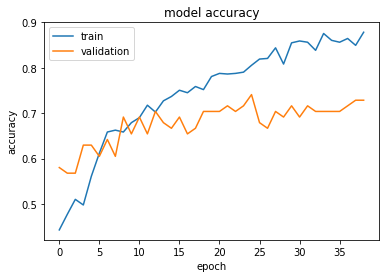

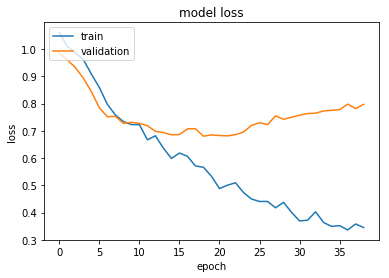

In [16]:
########################################
## define the model structure
########################################
def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    return conf  


def build_model(max_seq_len,  config): 
    num_of_classes = 3
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(nb_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False,name="embedding")
    embedded_sequences = embedding_layer(sequence_input)
    lstm1 = LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], name="lstm1")(embedded_sequences)
    lstm2 = LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'], name="lstm2")(lstm1)    
    predictions = Dense(num_of_classes, activation='softmax',name="predictions")(lstm2)
    full_model = Model(inputs=[sequence_input], outputs=[predictions])
    full_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
    return full_model


logs_dir = "logs"
rmtree(logs_dir, ignore_errors=True)
os.makedirs(logs_dir)
# Log to tensorboard
tensorBoardCallback = TensorBoard(log_dir=logs_dir,histogram_freq=1)#,embeddings_freq=1 , write_graph=True
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
# history = {}
# filename = ""
# checkpoint
# filepath= model_results_root_dir + "/weights.best.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
callbacks_list = [  reduce_lr, early_stopping, tensorBoardCallback]  # checkpoint, 

print(train_labels[:2])
print(train_padded_sequence[:2])
config = get_config()

K.clear_session()
model = build_model(max_seq_len,config)

history = model.fit(x=train_padded_sequence,
                      y=train_labels, 
                      batch_size=32,
                      epochs=100,
                      verbose=1,
                      shuffle=True,
                      callbacks=callbacks_list,
                      validation_split=0.1)
model_results_root_dir = "model/"
pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])    

90/90 [==============================] - 0s 1ms/step
['loss', 'acc'] [0.6485717376073201, 0.7333333320087857]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 455  97
  115 280 150 314 280 117  15  37 627 143 115  12]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  94   4
    6  57  31   7 236 257 488 128 372 987  16  33]]
90/90 [==============================] - 0s 1ms/step
y_true [0 1 1 0 0 2 0 1 1 1 1 0 0 0 1 2 2 1 0 1 1 1 1 1 2 0 1 1 0 1 2 2 2 1 0 2 2
 0 2 0 0 0 2 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 2 0 0 0 0 2 0 2 1 1
 1 0 0 2 1 0 0 0 1 0 2 0 1 1 0 0] 

y_true OrderedDict([(0, 42), (1, 32), (2, 16)]) 

y_pred [0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 2 1 1 0 1 1 1 1 1 1 0 1 1 1 0 2 2 2 1 1 2 0
 0 2 0 2 2 2 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 2 1 0 0 2 0 0 0 1
 1 2 0 0 1 1 0 0 0 1 2 2 1 1 0 0] 

y_pred OrderedDict([(0, 44), (1, 32), (2, 14)]) 



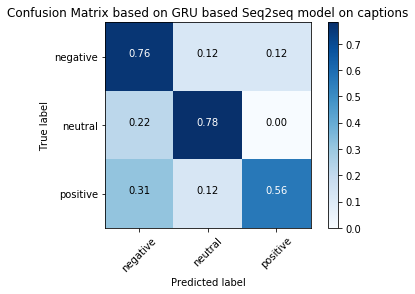

In [37]:
results = model.evaluate(test_padded_sequence, test_labels, verbose=1) # batch_size=1,
print(model.metrics_names, results)
print(test_padded_sequence[:2])
predictions = model.predict(test_padded_sequence, verbose=1)    
predictions = np.argmax(predictions, axis=-1) #multiple categories
# predictions = to_categorical(np.asarray(predictions), num_classes=3)
y_true = np.argmax(test_labels, axis=-1)
print("y_true", y_true,"\n")
print("y_true",pt.get_label_count(y_true),"\n")
y_pred = predictions
print("y_pred", y_pred,"\n")
print("y_pred",pt.get_label_count(y_pred),"\n")
titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)